# Fit bambi model to males and females combined

In [1]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.25

import jax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from aging.behavior.bio_age_model import (
    fit_model,
    raise_dim,
    constrained_fit
)
from sklearn.metrics import median_absolute_error

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.25


In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig4-wheel", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_


def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [4]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = sns.lineplot(
        data=age_df,
        x="true_ages",
        y="bio_ages",
        hue="labels",
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        legend=False,
        zorder=-1,
        lw=0.25,
        err_kws=dict(lw=0),
    )
    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        aspect="equal",
        xlim=(0, 120),
    )
    sns.despine()
    return fig

In [5]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col

In [6]:
def read_wheel(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/wheel_raw_counts_matrix_v00_post_processing.parquet"
    )

    df = df[use_syllables]
    df = df.reset_index(level=['experiment_type', 'age_group'])

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/wheel_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    # round ages
    ages = size_df.index.get_level_values('age')
    week_floor = np.round(ages).astype(int)
    size_df = size_df.reset_index(level='age')
    size_df['age'] = week_floor
    size_df = size_df.set_index('age', append=True)

    # fix mouse label
    mice = pd.Series(size_df.index.get_level_values('mouse'))
    size_df = size_df.reset_index('mouse')
    mice.loc[mice == '12wc3_0'] = '12c3_04'
    size_df['mouse'] = mice.to_numpy()
    size_df = size_df.set_index('mouse', append=True)

    df = df.join(size_df[['quant_0.5']])

    df = df.reset_index(level='age')

    # combine consecutive weeks
    df['age'] = (df['age'] // 2) * 2

    df['quant_0.5'] = df.groupby('age')['quant_0.5'].transform(zscore)
    df['quant_0.5'] = df['quant_0.5'].fillna(0)

    df = df.set_index(['age', 'experiment_type', 'age_group'], append=True)

    return df

In [7]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [8]:
df, sizes_col = read_male_ontogeny(keep_syllables)

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy()
}

age_sd = 0.125

hypparams = {
    "log_age": True,
    "min_age": 2,
    "max_age": 125,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.25,
    "n_opt_iter": 100,
    "log_scale_sd": True,
}

## Fit age + size model on male ontogeny data 

In [9]:
mdl = fit_model(features, hypparams, 2, return_loss_on_error=False)

if len(mdl) == 1:
    print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())

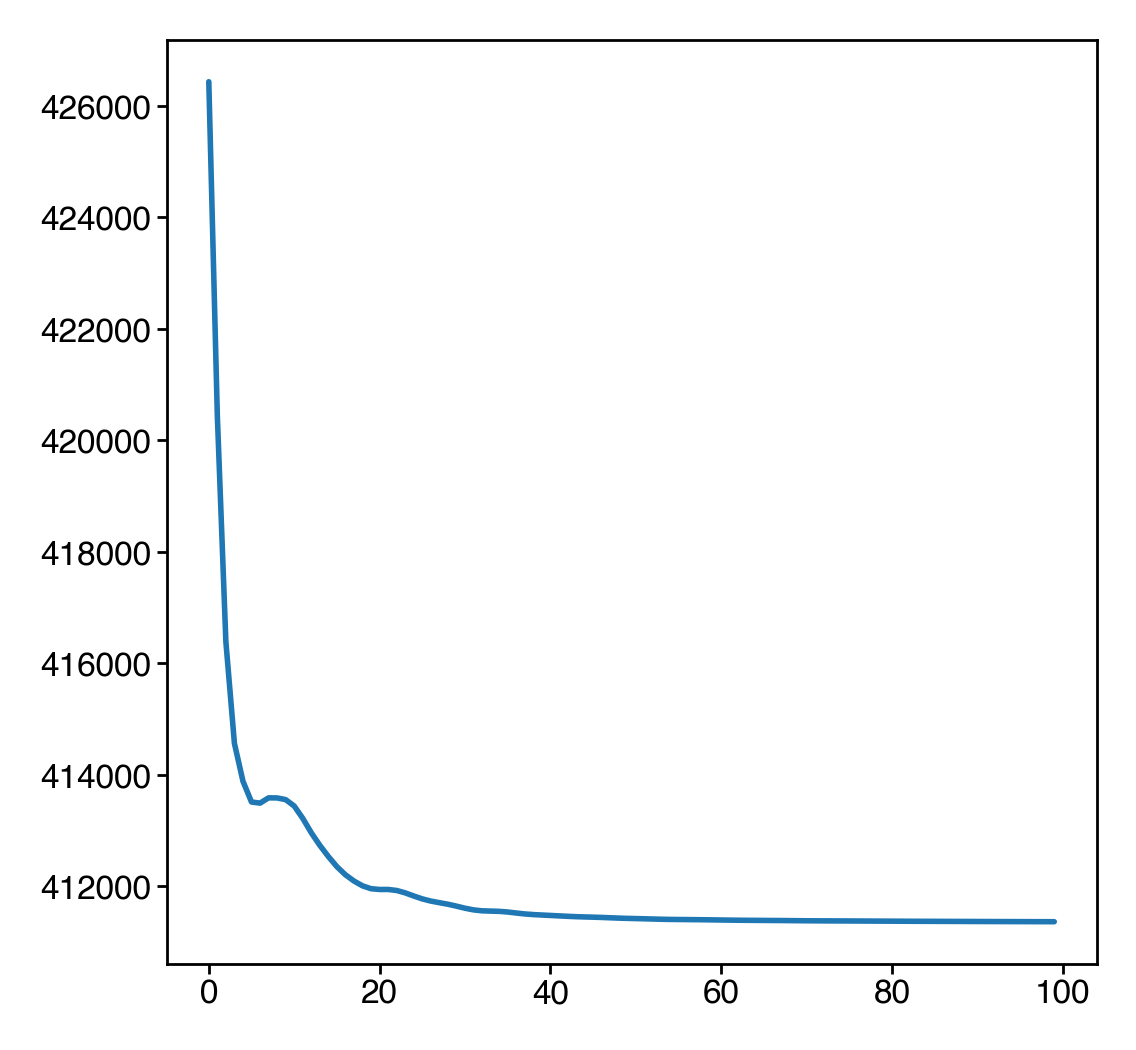

In [10]:
plt.plot(mdl['loss'])

In [11]:
median_absolute_error(mdl['true_ages'], mdl['bio_ages'])

1.8954849

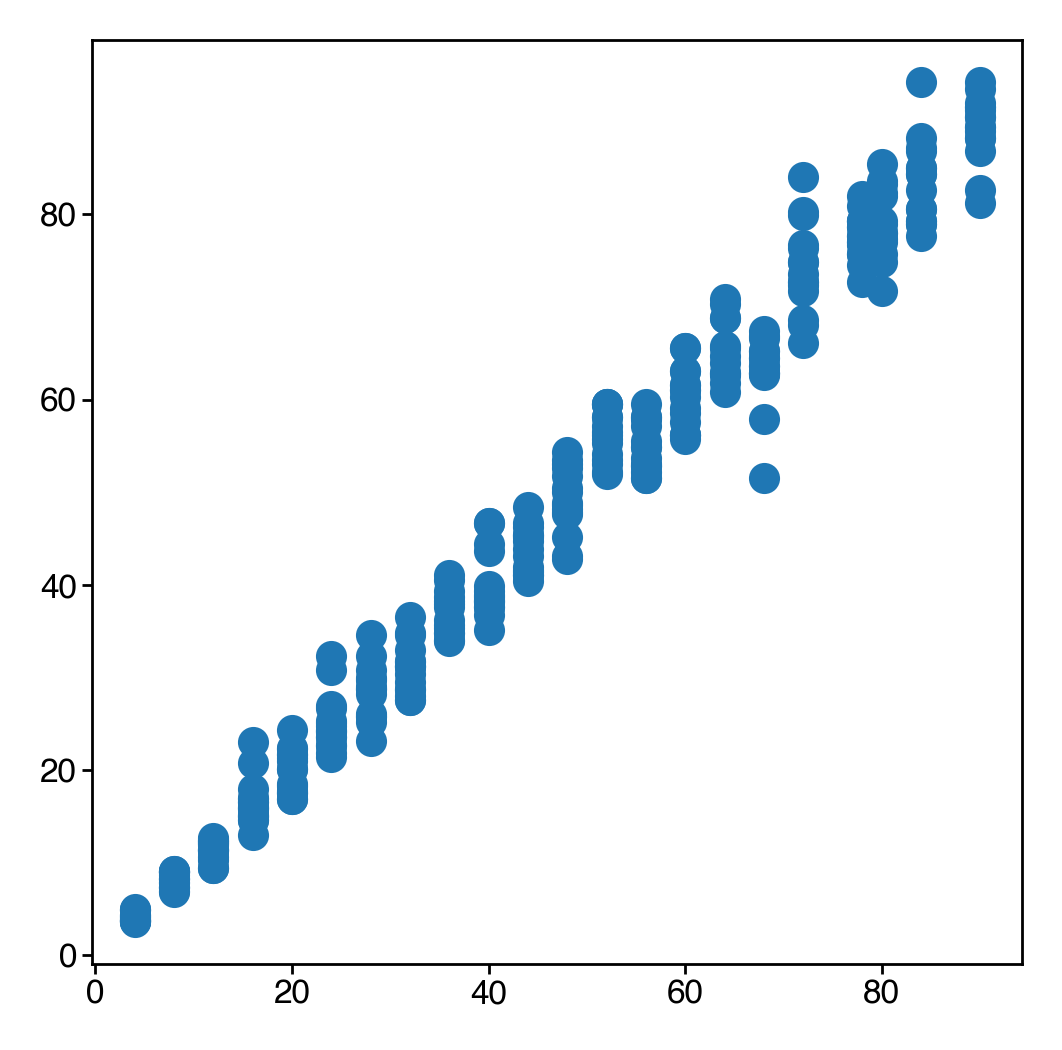

In [12]:
plt.scatter(mdl['true_ages'], mdl['bio_ages'])

## Fit a constrained model on wheel data

- Only fit the individuality parameter

In [13]:
wheel_df = read_wheel(keep_syllables).droplevel(['uuid', 'date', 'subject_name', 'session_name'])

In [14]:
index_names = wheel_df.index.names

In [15]:
wheel_df = wheel_df.groupby(index_names).mean()

In [16]:
wheel_df.head()

0     2      4     5     6     7  \
mouse   age experiment_type age_group                                        
12c1_01 12  control         young      10.5  80.5   64.5  52.5  29.0  33.0   
        14  control         young       5.0  56.0   69.0  88.0  33.0  86.0   
        16  control         young       4.5  44.5   96.0  89.0  29.5  53.5   
        18  control         young       4.0  59.0  140.0  71.0  17.0  37.0   
        20  control         young       5.5  46.0  133.5  74.5  20.5  50.5   

                                           9   10    11    12  ...    79  \
mouse   age experiment_type age_group                          ...         
12c1_01 12  control         young       90.0  5.0  52.5   8.5  ...  41.5   
        14  control         young      131.0  3.0  13.0  10.0  ...  39.0   
        16  control         young      100.5  5.5  28.0  10.5  ...  48.0   
        18  control         young       67.0  8.0  13.0   8.0  ...  66.0   
        20  control         young      102.0  5.5  18.0   5.0  ...  53.0   

                                         83    84    85     90    93    95  \
mouse   age experiment_type age_group                                        
12c1_01 12  control         young      20.5  26.5   6.0   56.5  11.0  12.0   
        14  control         young      20.0  24.0   4.0  115.0  16.0  19.0   
        16  control         young      21.0  24.0  12.0   97.0  22.0  27.0   
        18  control         young      28.0  29.0  13.0   90.0  27.0  20.0   
        20  control         young      12.5  36.0   6.5   81.5  19.0  19.5   

                                         97     98  quant_0.5  
mouse   age experiment_type age_group                          
12c1_01 12  control         young      35.5   46.0  -0.225909  
        14  control         young      23.0   54.0   0.014221  
        16  control         young      44.5  102.5  -0.131969  
        18  control         young      41.0  152.0   0.005032  
        20  control         young      41.5   64.5  -0.313148  

[5 rows x 59 columns]

In [17]:
wheel_size_col = wheel_df['quant_0.5'].to_numpy()

wheel_syllable_counts_jax = jnp.array(wheel_df.drop(columns=['quant_0.5']).astype(float))

In [18]:
wheel_age = wheel_df.index.get_level_values('age')

In [19]:
label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)

mouse_ids = label_encoder.fit_transform(wheel_df.index.get_level_values("mouse").to_numpy()[:, None]).T
mouse_cat = label_encoder.categories_[0]

In [20]:
wheel_features = {
    "ages": jnp.array(wheel_age, dtype=jnp.float32),  # models >= 1
    "counts": wheel_syllable_counts_jax + 1,  # models >= 1
    "sizes": jnp.array(wheel_size_col),
    "mice": jnp.array(mouse_ids),
}

wheel_hypparams = deepcopy(hypparams)
wheel_hypparams["n_animals"] = len(mouse_ids)
wheel_hypparams['n_opt_iter'] = 50
wheel_hypparams['age_sd'] = 0.125

# this forces the identity factors to incorporate an experiment-specific
# syllable offset to account for "batch effects"
wheel_hypparams['zero_mean'] = True

In [21]:
fixed_params = mdl['params']

In [22]:
list(fixed_params)

['bio_basis_weights', 'size_slope']

In [23]:
wheel_mdl = constrained_fit(wheel_features, fixed_params, wheel_hypparams, 5, return_loss_on_error=False)

if len(wheel_mdl) == 1:
    print(wheel_hypparams['n_opt_iter'] - np.isnan(wheel_mdl['loss']).sum())

In [24]:
mask = wheel_mdl['true_ages'] > 40
median_absolute_error(wheel_mdl['true_ages'][mask], wheel_mdl['bio_ages'][mask])

5.934311

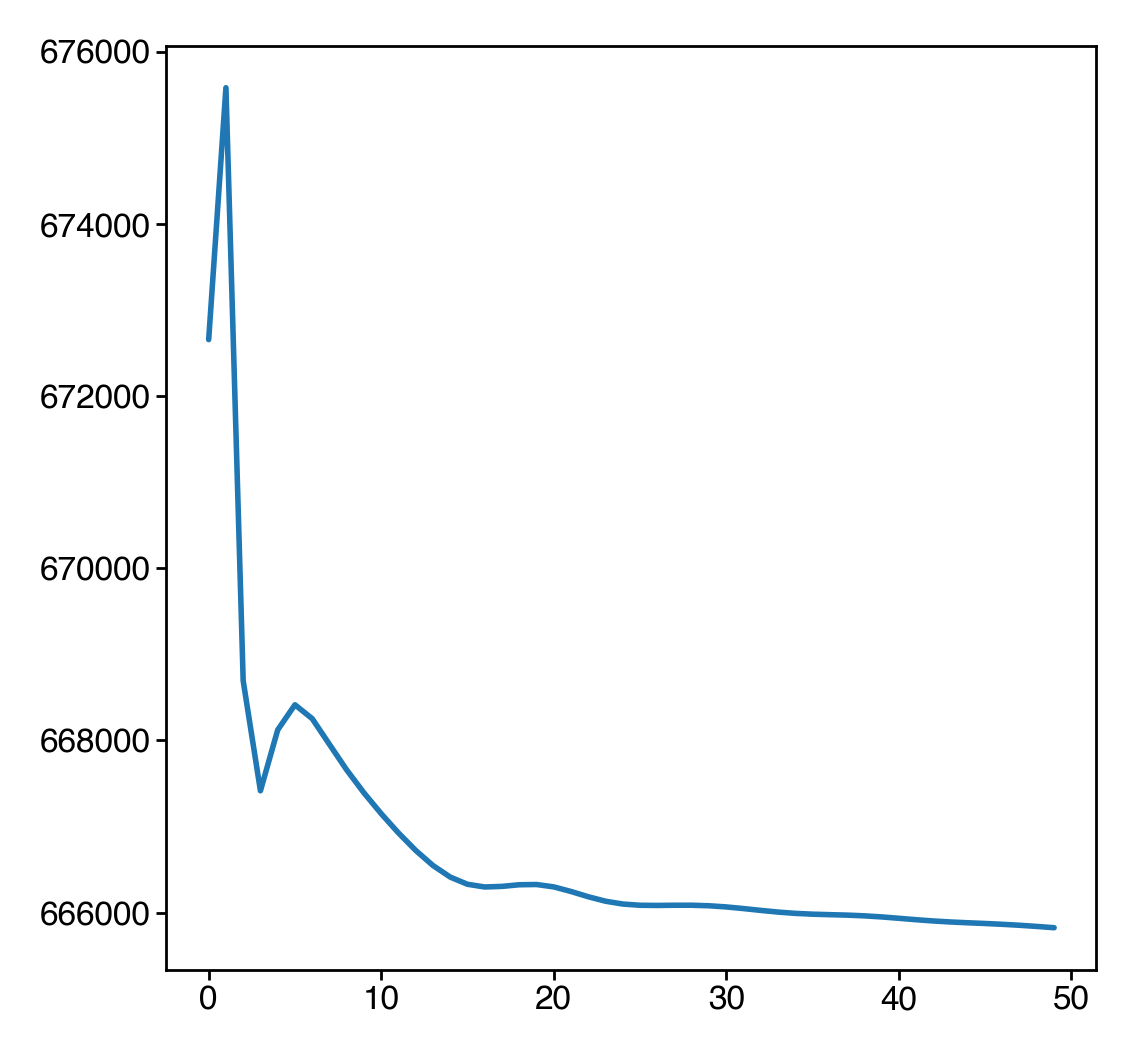

In [25]:
plt.plot(wheel_mdl['loss'])

In [26]:
list(wheel_mdl['params'])

['development_weights', 'individual_biases', 'bio_basis_weights', 'size_slope']

In [27]:
ind_bias = wheel_mdl['params']['individual_biases']
if wheel_hypparams['zero_mean']:
    ind_bias = raise_dim(ind_bias, axis=1)

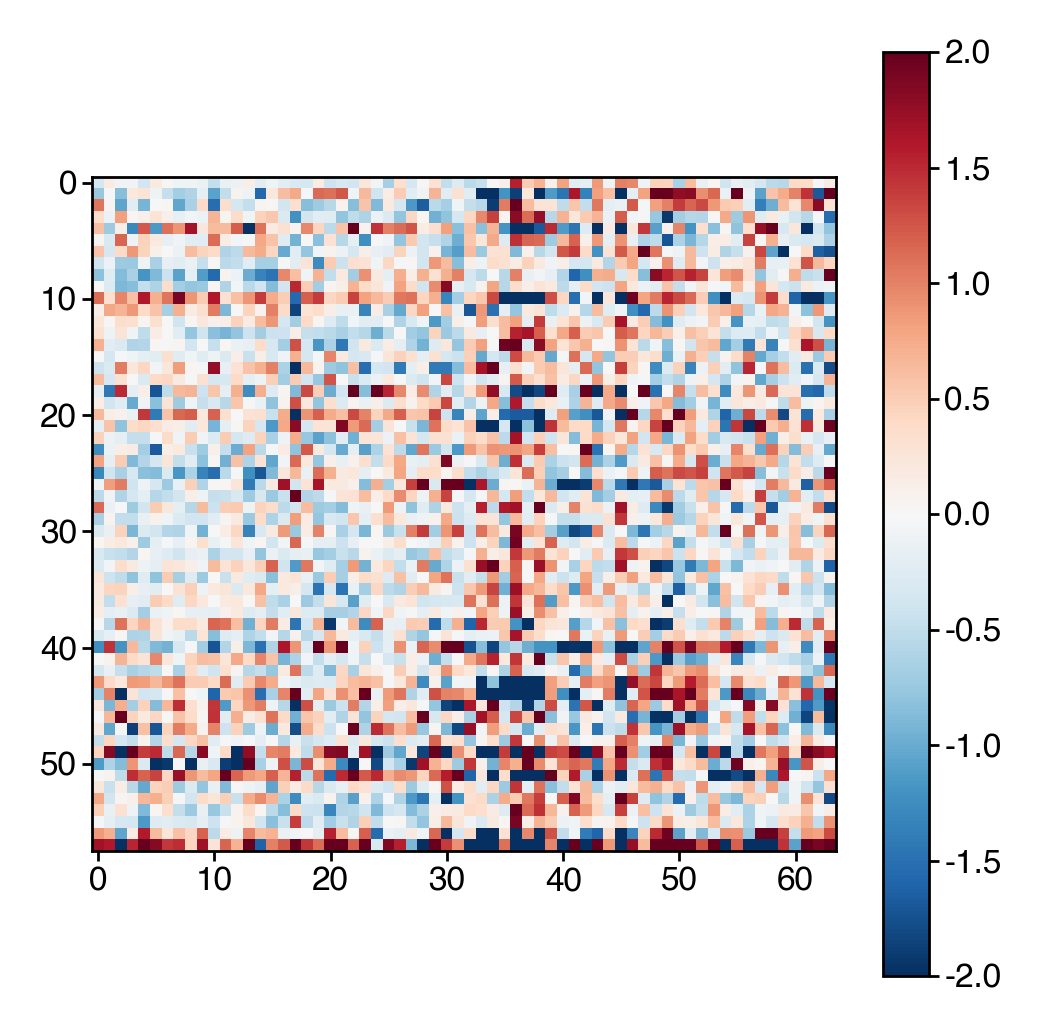

In [28]:
plt.imshow(ind_bias, cmap='RdBu_r', vmin=-2, vmax=2)
plt.colorbar()

<Axes: >

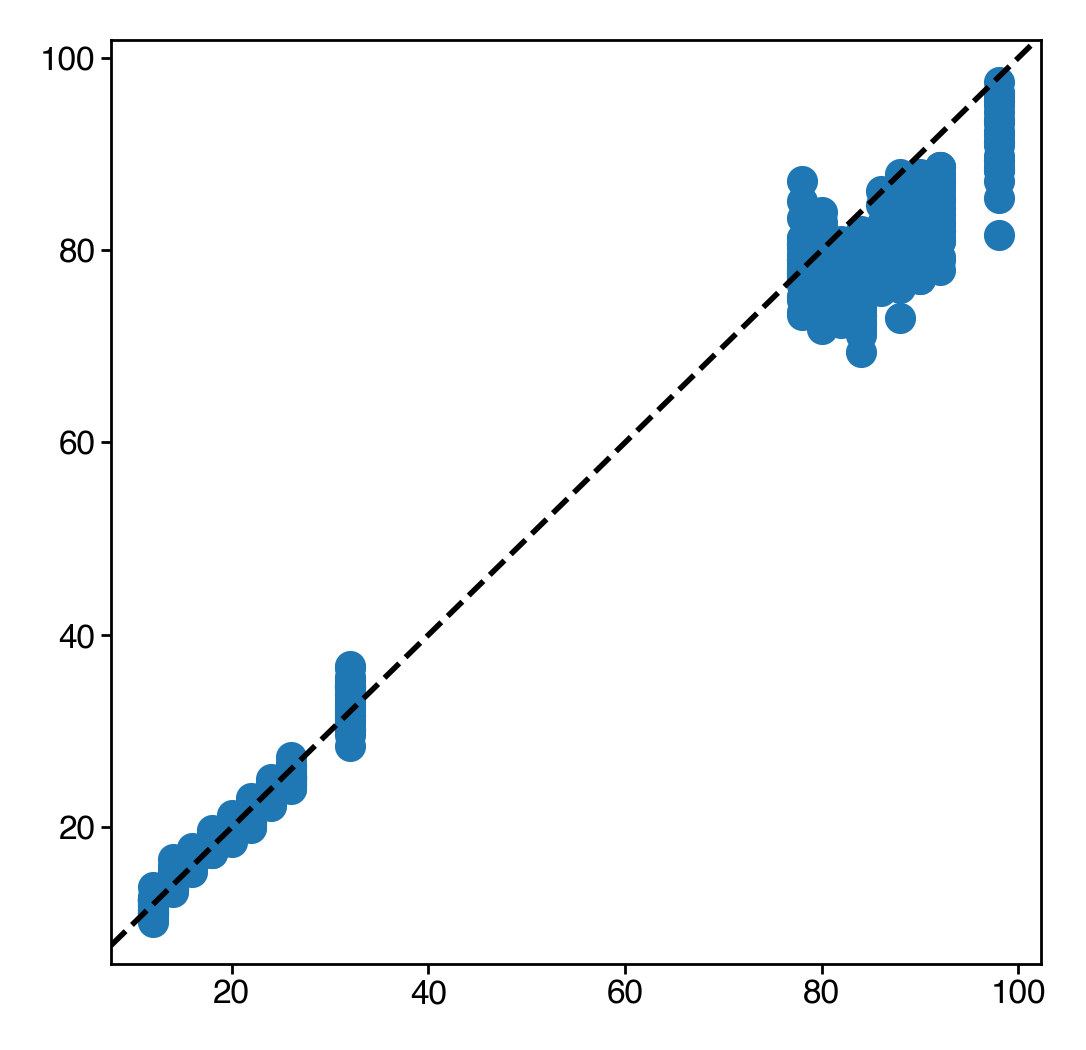

In [29]:
plt.scatter(wheel_mdl['true_ages'], wheel_mdl['bio_ages'])
add_identity(plt.gca(), color='k', ls='--')

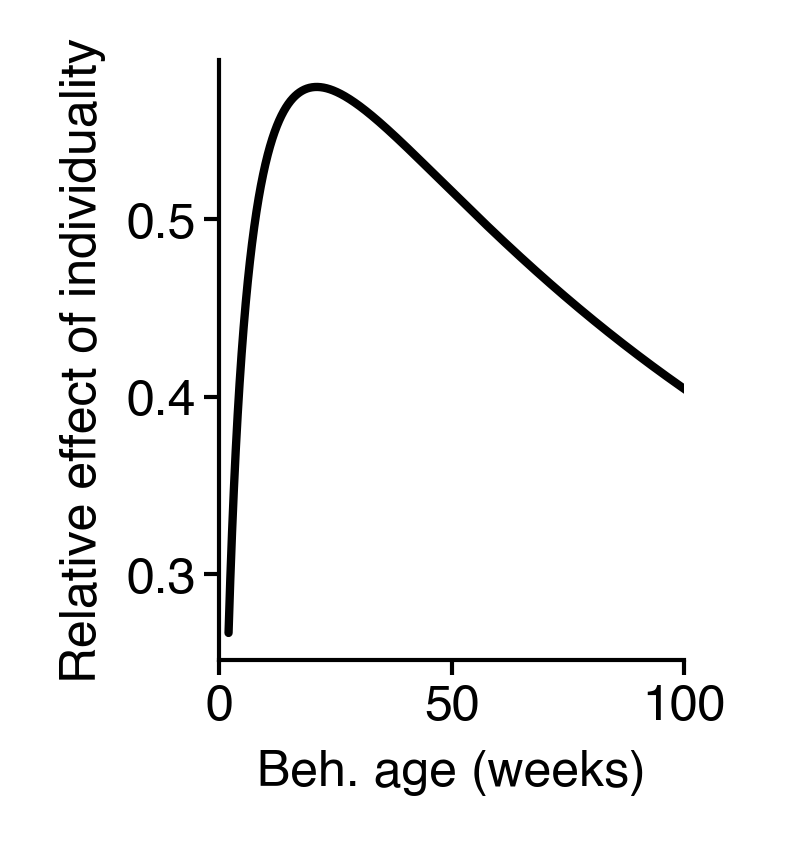

In [30]:
comps = wheel_mdl['init_components']

x = wheel_mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of individuality")
sns.despine()
saver(fig, "ontogeny-effect-of-sex");

## Make dataframe

In [31]:
wheel_df['beh_age'] = wheel_mdl['bio_ages']

<Axes: xlabel='age', ylabel='beh_age'>

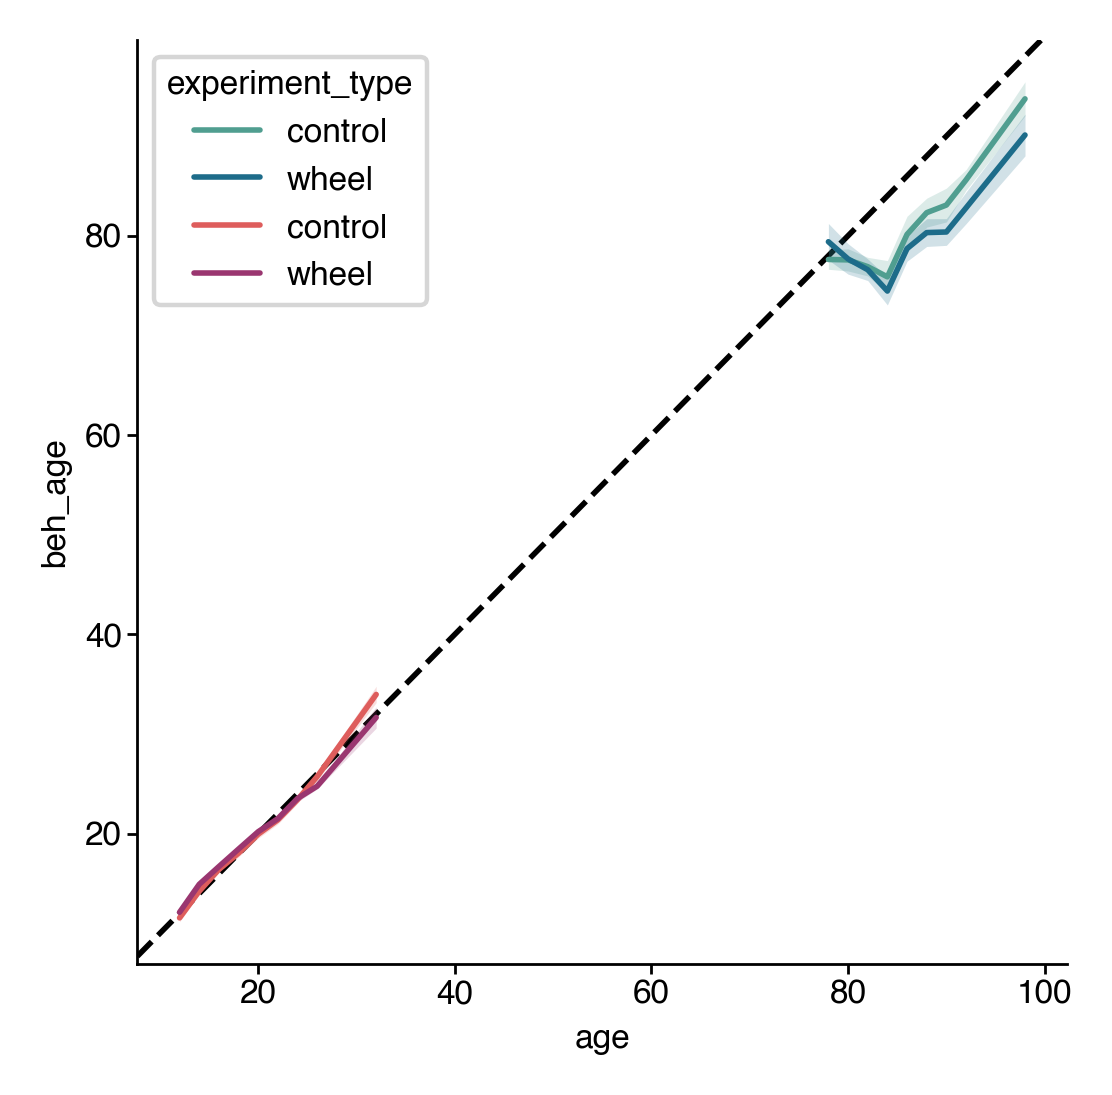

In [32]:
for (g, _df), palette in zip(wheel_df.groupby("age_group"), ["crest", "flare"]):
    sns.lineplot(
        data=_df.reset_index(),
        x="age",
        y="beh_age",
        hue="experiment_type",
        palette=palette,
        errorbar=("se", 2),
        err_kws=dict(lw=0),
    )
sns.despine()
add_identity(plt.gca(), color='k', ls='--', zorder=-1)

In [33]:
diff_samples = []
for i in range(500):
    diffs = []
    for age, _df in wheel_df.reset_index().groupby("age"):
        cb = (
            _df.loc[_df["experiment_type"] == "control", "beh_age"]
            .sample(frac=1, replace=True, random_state=i)
            .mean()
        )
        wb = (
            _df.loc[_df["experiment_type"] == "wheel", "beh_age"]
            .sample(frac=1, replace=True, random_state=i)
            .mean()
        )
        diffs.append((age, wb - cb))
    diffs = dict(diffs)
    diff_samples.append(diffs)

In [34]:
diff_samples = pd.DataFrame(diff_samples)
diff_samples.columns.name = 'age'

In [35]:
melt_diff = diff_samples.T.reset_index().melt(id_vars='age')

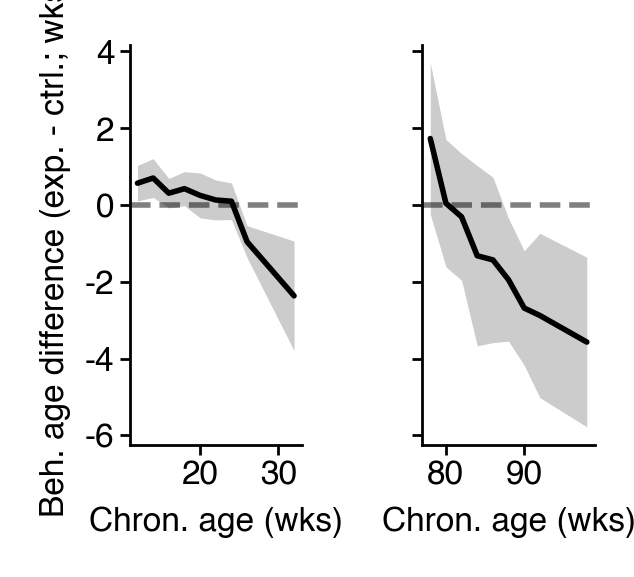

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(1.5, 1.3), sharey=True, gridspec_kw={'wspace': 0.7})
for i in range(2):
    if i == 0:
        plt_data = melt_diff.query('age < 50')
    else:
        plt_data = melt_diff.query('age > 50')
    a = sns.lineplot(data=plt_data, x='age', y='value', errorbar=('sd', 2), color='k', err_kws=dict(lw=0), ax=ax[i])
    a.axhline(0, ls='--', color='gray', zorder=-1)
    a.set(ylabel="Beh. age difference (exp. - ctrl.; wks)", xlabel="Chron. age (wks)")
sns.despine()
saver(fig, "wheel-residuals-bambi");

In [37]:
out = []
for (exp, age_group, mouse), _df in wheel_df.groupby(['experiment_type', 'age_group', 'mouse']):
    avgd_age = _df.sort_index(level='age', ascending=False)['beh_age'].rolling(5, center=True, min_periods=1, win_type="exponential").mean(tau=1.0).iloc[::2].iloc[::-1]
    out.append(avgd_age - avgd_age.values[0])

In [38]:
out = pd.concat(out).reset_index()

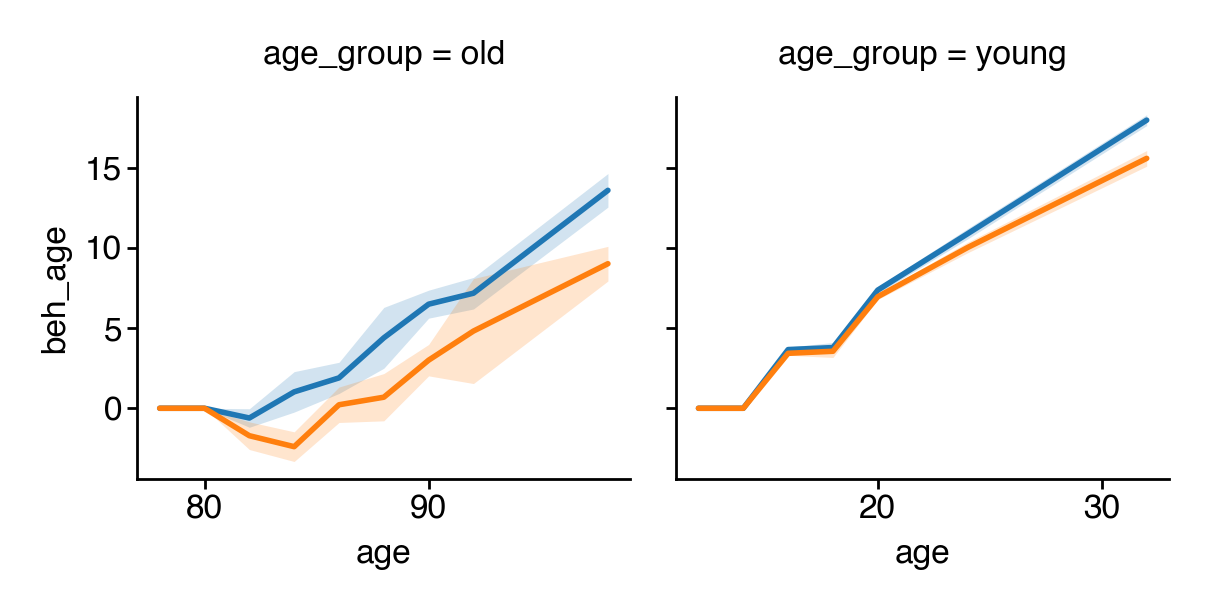

In [39]:
fgrid = sns.FacetGrid(data=out, col="age_group", sharex=False, height=1.5, hue="experiment_type")
fgrid.map(sns.lineplot, "age", "beh_age", errorbar=("se", 1), err_kws=dict(lw=0))

## Plot velocity

In [40]:
import polars as pl

In [41]:
full_df = pl.scan_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/wheel_syllable_df_v00.parquet')

avg_velocities = full_df.group_by(
    ['uuid', 'age', 'mouse']
).agg(pl.col("velocity_2d_mm").mean() * 30).collect()

In [42]:
pd_avg_velocities = avg_velocities.to_pandas()
ages = pd_avg_velocities['age']
week_floor = np.round(ages).astype(int)
pd_avg_velocities['age'] = week_floor
pd_avg_velocities['age'] = (pd_avg_velocities['age'] // 2) * 2
pd_avg_velocities = pd_avg_velocities.groupby(['mouse', 'age'])['velocity_2d_mm'].mean()

joined_df = wheel_df.reset_index(level=['experiment_type', 'age_group']).join(pd_avg_velocities)
joined_df = joined_df.set_index(['experiment_type', 'age_group'], append=True)
joined_df = joined_df.rename_axis(index={'experiment_type': 'exp', 'age_group': 'grp'})

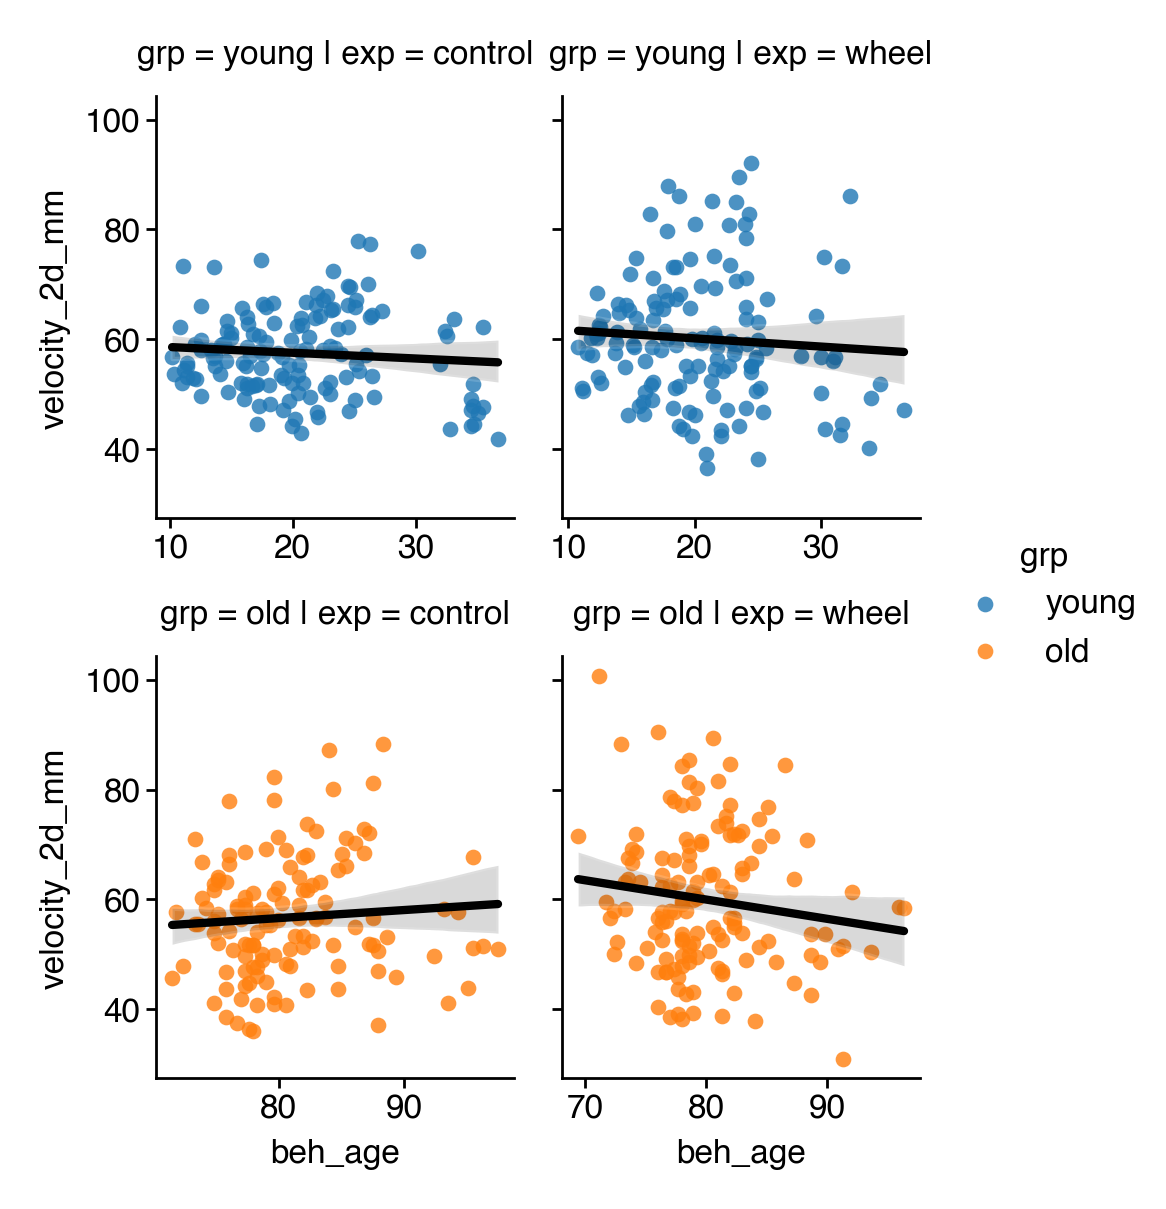

In [43]:
fgrid = sns.FacetGrid(data=joined_df.reset_index(), col='exp', row="grp", hue='grp', height=1.5, sharex=False, aspect=0.8)
fgrid.map(sns.regplot, 'beh_age', 'velocity_2d_mm', scatter_kws=dict(linewidths=0, s=8), line_kws=dict(color='k'))
fgrid.add_legend()

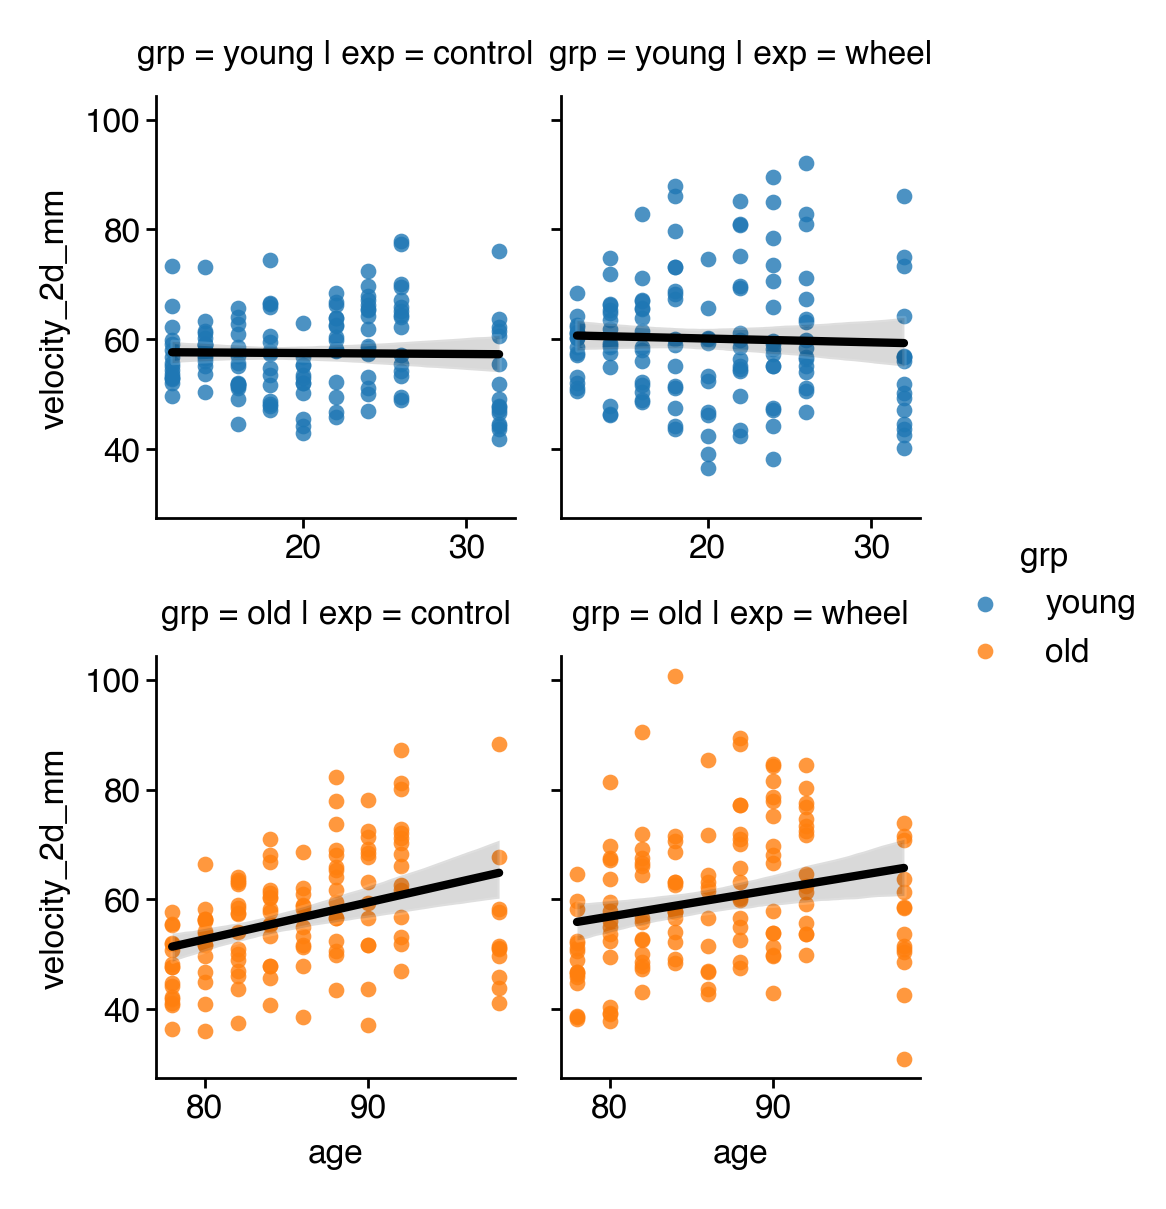

In [44]:
fgrid = sns.FacetGrid(data=joined_df.reset_index(), col='exp', row="grp", hue='grp', height=1.5, sharex=False, aspect=0.8)
fgrid.map(sns.regplot, 'age', 'velocity_2d_mm', scatter_kws=dict(linewidths=0, s=8), line_kws=dict(color='k'))
fgrid.add_legend()

## Plot syllable use

In [45]:
sylls = [c for c in wheel_df.columns if str(c).isdigit()]

In [47]:
oldest = wheel_df.sort_index(level='age').reset_index().groupby('mouse').last()
youngest = wheel_df.sort_index(level='age').reset_index().groupby('mouse').first()

In [48]:
young_copy = youngest.copy()
young_copy[sylls] = np.log(young_copy[sylls] + 1)
yd = young_copy.query('age_group == "young"').groupby('experiment_type')[sylls].mean()
yzs = ((yd.loc['wheel'] - yd.loc['control']) / young_copy.query('age_group == "young" & experiment_type == "control"')[sylls].std()).sort_values()

old_copy = oldest.copy()
old_copy[sylls] = np.log(old_copy[sylls] + 1)
od = old_copy.query('age_group == "young"').groupby('experiment_type')[sylls].mean()
ozs = ((od.loc['wheel'] - od.loc['control']) / old_copy.query('age_group == "young" & experiment_type == "control"')[sylls].std()).sort_values()

change_diffs = (ozs - yzs).sort_values()

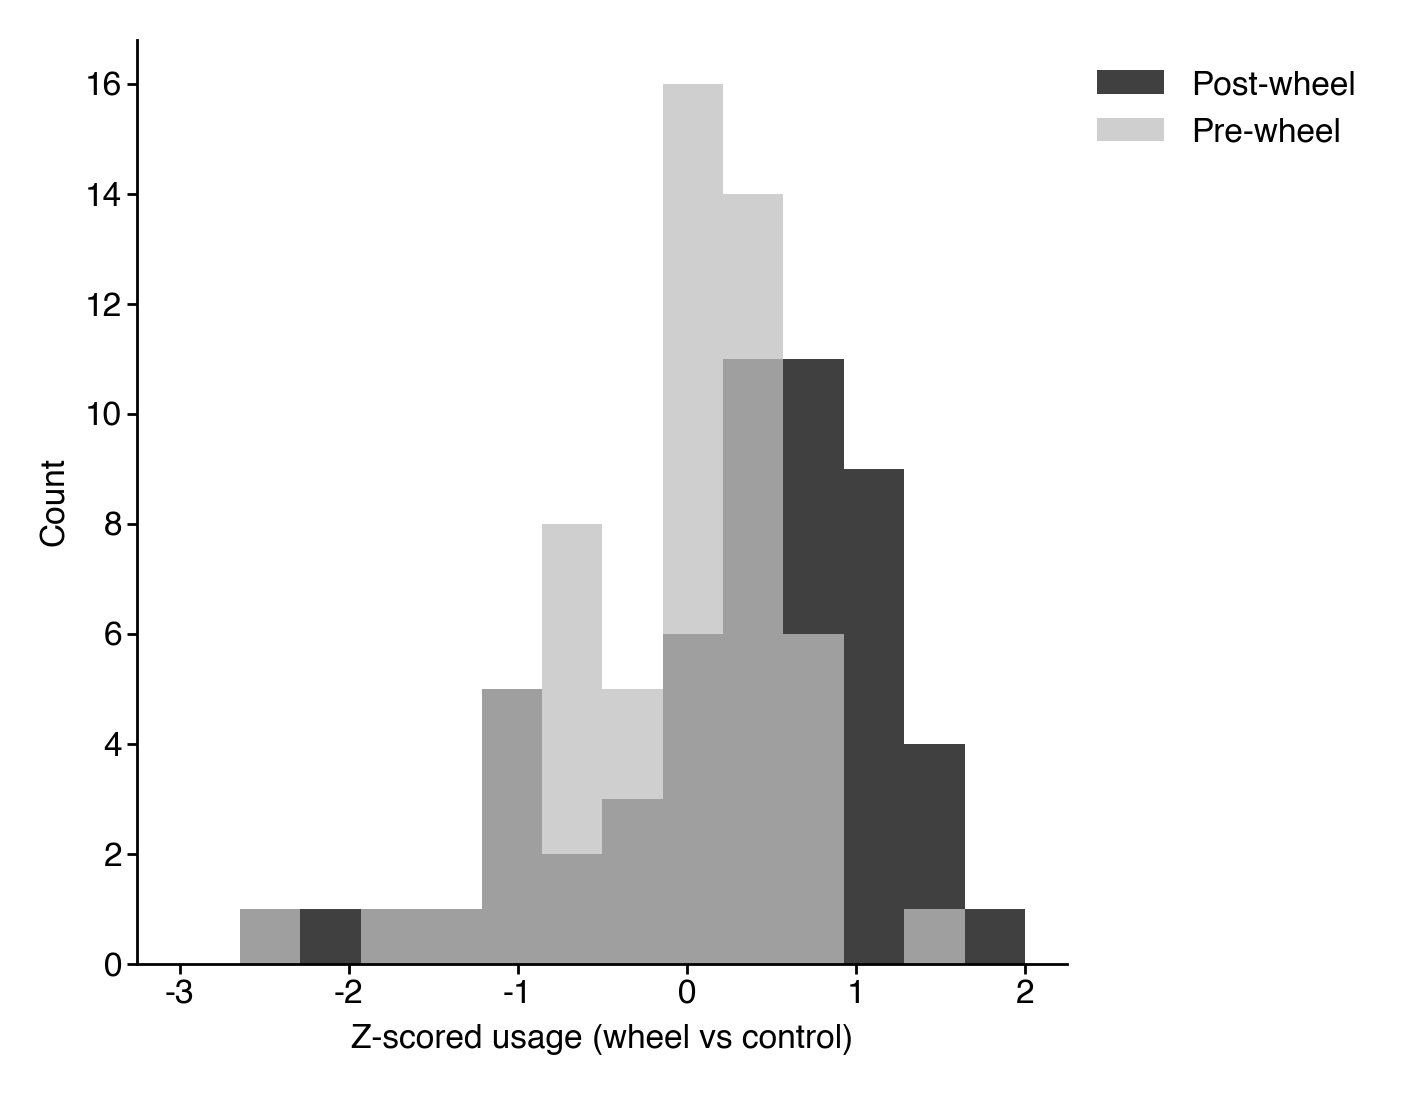

In [49]:
ax = sns.histplot(ozs, element="step", lw=0, color='k', label="Post-wheel", alpha=0.75, bins=np.linspace(-3, 2, 15))
ax = sns.histplot(yzs, element="step", lw=0, color='silver', label="Pre-wheel", alpha=0.75, bins=np.linspace(-3, 2, 15))
ax.set(xlabel="Z-scored usage (wheel vs control)")

legend(ax)
sns.despine()

In [50]:
young_copy = youngest.copy()
young_copy[sylls] = np.log(young_copy[sylls] + 1)
yd = young_copy.query('age_group == "old"').groupby('experiment_type')[sylls].mean()
yzs = ((yd.loc['wheel'] - yd.loc['control']) / young_copy.query('age_group == "old" & experiment_type == "control"')[sylls].std()).sort_values()

old_copy = oldest.copy()
old_copy[sylls] = np.log(old_copy[sylls] + 1)
od = old_copy.query('age_group == "old"').groupby('experiment_type')[sylls].mean()
ozs = ((od.loc['wheel'] - od.loc['control']) / old_copy.query('age_group == "old" & experiment_type == "control"')[sylls].std()).sort_values()

old_change_diffs = (ozs - yzs).sort_values()

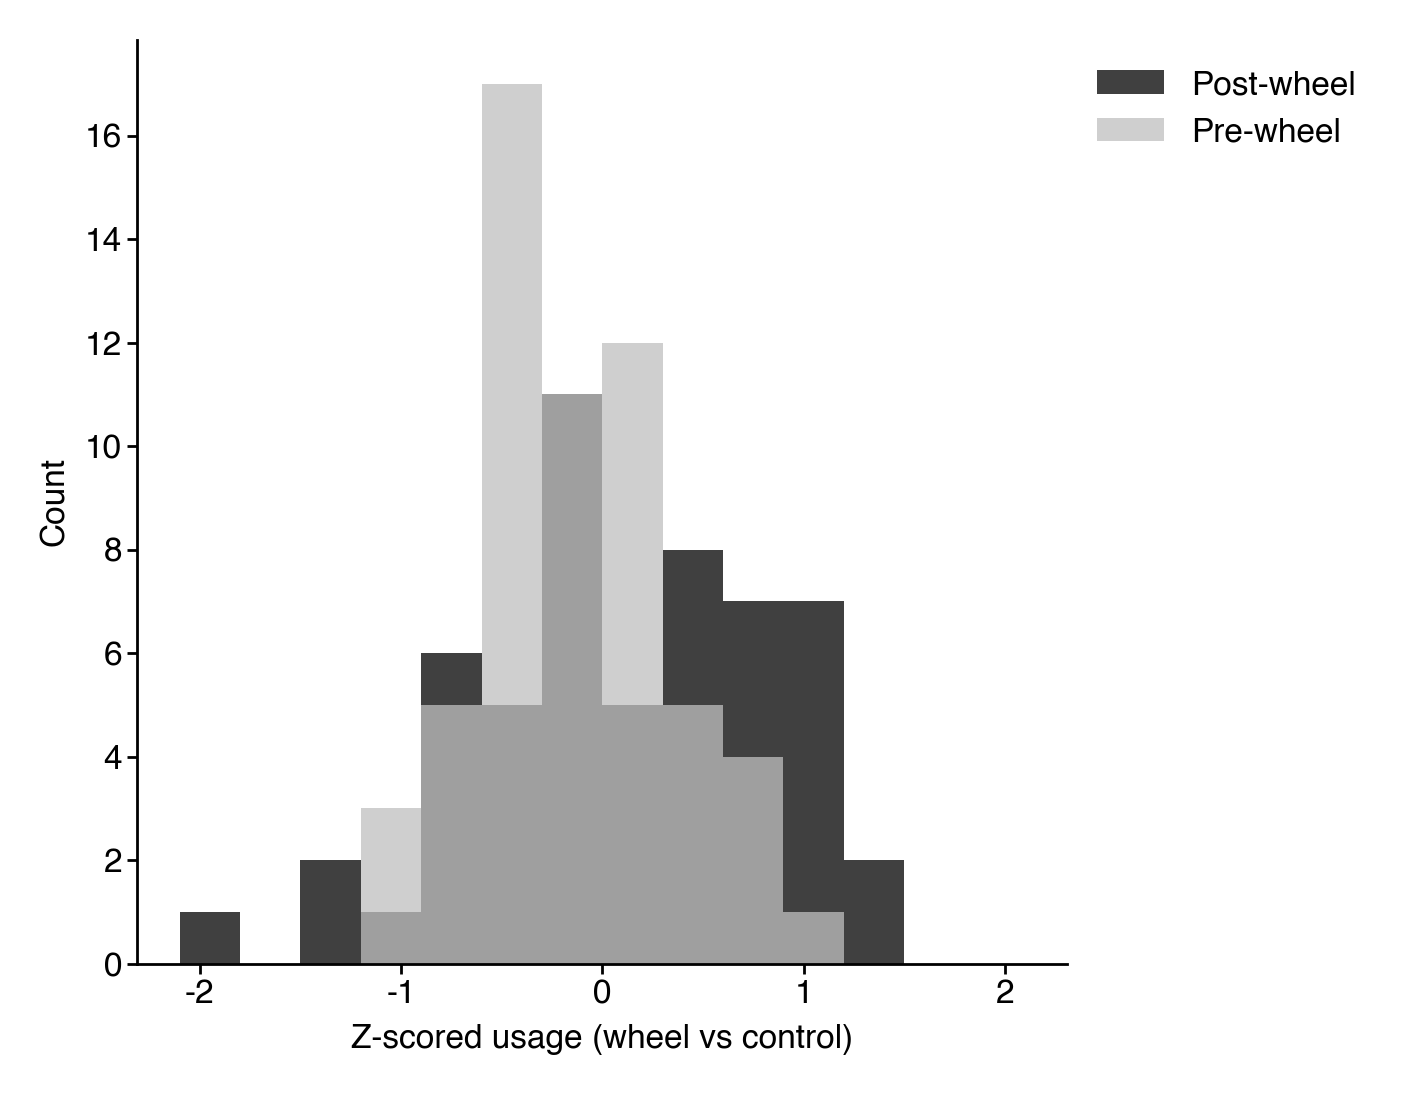

In [51]:
ax = sns.histplot(ozs, element="step", lw=0, color='k', label="Post-wheel", alpha=0.75, bins=np.linspace(-2.1, 2.1, 15))
ax = sns.histplot(yzs, element="step", lw=0, color='silver', label="Pre-wheel", alpha=0.75, bins=np.linspace(-2.1, 2.1, 15))
ax.set(xlabel="Z-scored usage (wheel vs control)")

legend(ax)
sns.despine()

In [52]:
# combine pre/post-wheel data
youngest['treatment'] = 'Pre'
oldest['treatment'] = 'Post'

In [54]:
combined = pd.concat([youngest, oldest])
combined['experiment_type'] = combined['experiment_type'].str.capitalize()
combined['age_group'] = combined['age_group'].str.capitalize()

In [55]:
def plot_wheel_usages(df, syllable, comparison="treatment"):
    """comparison: treatment OR experiment_type"""
    if comparison == "treatment":
        order = ["Control", "Wheel"]
        xax = "experiment_type"
    elif comparison == "experiment_type":
        order = ["Pre", "Post"]
        xax = "treatment"

    fgrids = {}
    for ag, _df in df.groupby('age_group'):
        fgrid = sns.FacetGrid(data=_df, col=comparison, height=1.3, aspect=0.7)
        fgrid.map(sns.stripplot, xax, syllable, color='silver', size=2.5, order=order, zorder=-1)
        fgrid.map(sns.pointplot, xax, syllable, color='k', order=order, ms=3.5, errorbar=('se', 2))
        fgrid.set_titles(template=f"{syllable}: {ag} - {{col_name}}")
        fgrid.set_xlabels("")
        fgrid.set_ylabels("Syllable counts")
        for a in fgrid.axes.flat:
            a.tick_params(axis='x', rotation=90)
        fgrids[ag] = fgrid
    return fgrids

## Compute syllable use for young and old bambi beh. ages

In [58]:
combined['residual'] = combined['beh_age'] - combined['age']
combined['beh_age_class'] = combined.groupby('age_group')['residual'].transform(lambda x: pd.qcut(x, 2, labels=False))

In [69]:
def plot_beh_age_usages(syllable):
    _corrs = wheel_df.groupby('age_group')[['beh_age', syllable]].corr(method='spearman').loc[pd.IndexSlice[:, 'beh_age'], syllable]
    oc = _corrs.loc['old'].iloc[0]
    yc = _corrs.loc['young'].iloc[0]
    fgrid = sns.lmplot(
        data=wheel_df.reset_index().rename(columns=str),
        col="age_group",
        x="beh_age",
        y=str(syllable),
        height=1.3,
        aspect=0.7,
        scatter_kws=dict(color='silver', linewidths=0.2, s=5, edgecolor='k', alpha=1),
        line_kws=dict(color='k'),
        facet_kws=dict(sharex=False)
    )
    fgrid.set_titles(template=f"{syllable}: {{col_name}} old rho={oc:0.2f} young rho={yc:0.2f}")
    fgrid.set_xlabels("Beh. age (wks)")
    fgrid.set_ylabels("Syllable counts")

    return fgrid

In [70]:
age_syll_corrs = (
    wheel_df
        .groupby('age_group')
        .corr(method='spearman')
        .loc[pd.IndexSlice[:, 'beh_age'], :]
        .drop(columns=['quant_0.5', 'beh_age'])
        .mean()
        .sort_values()
)

In [ ]:
for syllable in age_syll_corrs.index:
    fgrid = plot_beh_age_usages(syllable)
    saver(fgrid.fig, f"beh-age-vs-syllable-counts-{syllable}")

In [ ]:
for syllable in age_syll_corrs.index:
    fgrids = plot_wheel_usages(combined, syllable, comparison="experiment_type")
    for age, fg in fgrids.items():
        saver(fg.fig, f"{age}-data-beh-age-corr-sorted-syllable-{syllable}-counts")

## Scatter beh. age corrs and wheel - control

In [72]:
age_syll_corrs = (
    wheel_df
        .groupby('age_group')
        .corr(method='spearman')
        .loc[pd.IndexSlice[:, 'beh_age'], :]
        .drop(columns=['quant_0.5', 'beh_age'])
)

In [73]:
old_copy = oldest.copy()
old_copy[sylls] = np.log(old_copy[sylls] + 1)
od = old_copy.query('age_group == "old"').groupby('experiment_type')[sylls].mean()
ozs = ((od.loc['wheel'] - od.loc['control']) / (old_copy.query('age_group == "old" & experiment_type == "control"')[sylls]).std()).sort_values()

In [84]:
c = ozs.corr(age_syll_corrs.loc['old'].T['beh_age'])
c

-0.6850548646471164

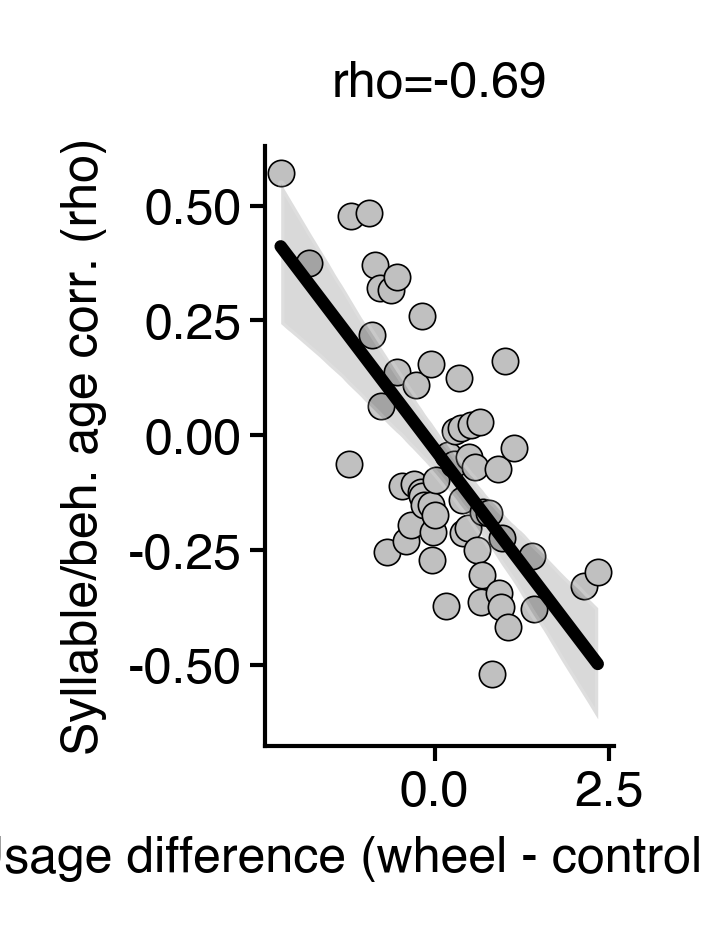

In [85]:
fig = figure(0.75, 1.3)
ax = sns.regplot(x=ozs, y=age_syll_corrs.loc['old'][ozs.index], scatter_kws=dict(color='silver', linewidths=0.2, edgecolor='k', s=10, alpha=1), line_kws=dict(color='k'))
ax.set(xlabel="Usage difference (wheel - control; z-score)", ylabel="Syllable/beh. age corr. (rho)", title=f"rho={c:0.2f}")
sns.despine()
saver(fig, "old-wheel-usage-diff-vs-syll-beh-age-corr");

In [86]:
old_copy = oldest.copy()
old_copy[sylls] = np.log(old_copy[sylls] + 1)
od = old_copy.query('age_group == "young"').groupby('experiment_type')[sylls].mean()
ozs = ((od.loc['wheel'] - od.loc['control']) / (old_copy.query('age_group == "young" & experiment_type == "control"')[sylls]).std()).sort_values()

In [87]:
c = ozs.corr(age_syll_corrs.loc['young'].T['beh_age'])
c

-0.5877249887873671

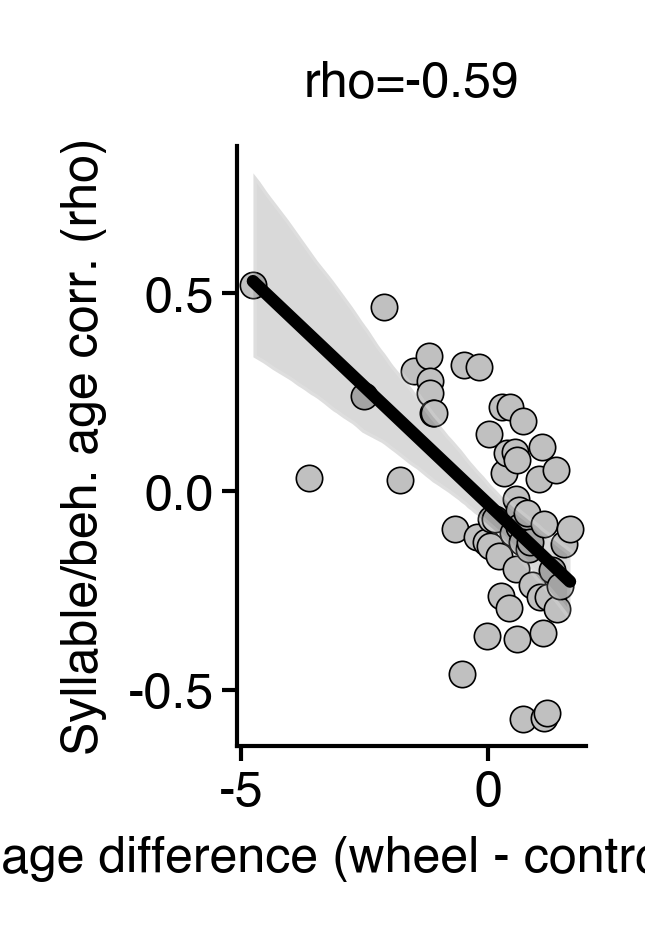

In [88]:
fig = figure(0.75, 1.3)
ax = sns.regplot(x=ozs, y=age_syll_corrs.loc['young'][ozs.index], scatter_kws=dict(color='silver', linewidths=0.2, edgecolor='k', s=10, alpha=1), line_kws=dict(color='k'))
ax.set(xlabel="Usage difference (wheel - control; z-score)", ylabel="Syllable/beh. age corr. (rho)", title=f"rho={c:0.2f}")
sns.despine()
saver(fig, "young-wheel-usage-diff-vs-syll-beh-age-corr");